# Import Libraries

In [5]:
#Basic tools
import pandas as pd
from datetime import datetime
import numpy as np

In [6]:
#train test split
from sklearn.model_selection import train_test_split


#function to get a mode of a dataset
from statistics import mode
#normalizing dataset
from sklearn.preprocessing import StandardScaler

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

#For resampling process to change the ratio of imbalanced ratio of the classes 
#testing various ratios
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
#resampling
from imblearn.over_sampling import SMOTE

# Load Data

In [33]:
train = pd.read_csv('train.csv')
campaign = pd.read_csv('campaign_data.csv')
coupon = pd.read_csv('coupon_item_mapping.csv')
demog = pd.read_csv('customer_demographics.csv')
transaction = pd.read_csv('customer_transaction_data.csv')
item = pd.read_csv('item_data.csv')
test = pd.read_csv('test.csv')

In [34]:
#To update data and save them easily, a dictionary is created. 
tables ={}
tables['train'] = train
tables['campaign'] = campaign
tables['coupon'] = coupon 
tables['demog'] = demog
tables['transaction'] = transaction 
tables['item'] = item
tables['test'] = test

# Exploratory Data Analysis

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78369 entries, 0 to 78368
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 78369 non-null  int64
 1   campaign_id        78369 non-null  int64
 2   coupon_id          78369 non-null  int64
 3   customer_id        78369 non-null  int64
 4   redemption_status  78369 non-null  int64
dtypes: int64(5)
memory usage: 3.0 MB


In [12]:
len(train.campaign_id.unique())

18

In [13]:
train.redemption_status.value_counts()

redemption_status
0    77640
1      729
Name: count, dtype: int64

In [14]:
729/(77640+729)*100

0.930214753282548

Does each campaign have distinct set of coupons or do coupons overlap in different campaigns?

In [15]:
coupon_uses ={}
for cp in train.coupon_id.unique():
    # key = number of campaigns that use the coupon
    key = len(train[train.coupon_id==cp].campaign_id.unique())
    if key in coupon_uses.keys():
        #collect coupon ids that were used key times
        coupon_uses[key].append(cp)
    else:
        coupon_uses[key] = [cp]

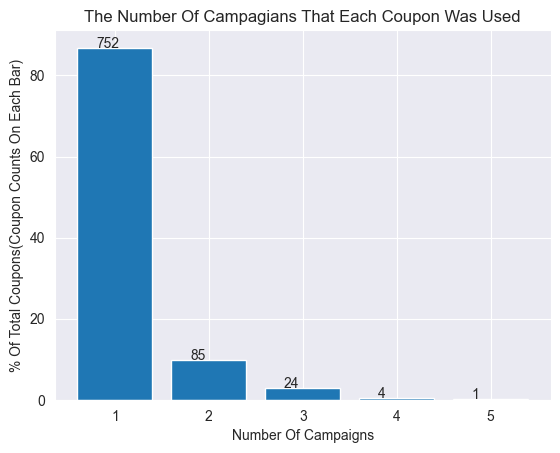

In [16]:

coupon_freq ={}
#coupon_freq 
#keys: the number of uses of coupons
#values:number of coupons 
for key in coupon_uses.keys():
    coupon_freq[key]= len(coupon_uses[key])/len(train.coupon_id.unique())*100

plt.bar(coupon_freq.keys(),coupon_freq.values())

# Text on the top of each barplot
label = [len(x) for x in coupon_uses.values()]
x_loc = np.array([x for x in coupon_freq.keys()])-0.2
y_loc = np.array([x for x in coupon_freq.values()]) + 0.1
for i in range(5):
    plt.text(x = x_loc[i] , y = y_loc[i], s = label[i], size = 10)
plt.title('The number of campagians that each coupon was used'.title())
plt.ylabel('% of total coupons(coupon counts on each bar)'.title())
plt.xlabel('number of campaigns'.title())
plt.show()

The answer is No... But most of coupons used only once for a particular campaign.

# Campaign Data Table

In [17]:

campaign.campaign_type.value_counts()

campaign_type
Y    22
X     6
Name: count, dtype: int64

In [18]:
campaign.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   campaign_id    28 non-null     int64 
 1   campaign_type  28 non-null     object
 2   start_date     28 non-null     object
 3   end_date       28 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.0+ KB


In [19]:
len(campaign.campaign_id.unique())

28

In [20]:
coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   coupon_id  92663 non-null  int64
 1   item_id    92663 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


# Coupon Item Mapping Table

In [21]:

coupon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92663 entries, 0 to 92662
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   coupon_id  92663 non-null  int64
 1   item_id    92663 non-null  int64
dtypes: int64(2)
memory usage: 1.4 MB


In [22]:

coupon.coupon_id.value_counts()

coupon_id
32      11814
23      11813
22       4947
31       4873
33       4394
        ...  
1057        1
54          1
470         1
48          1
784         1
Name: count, Length: 1116, dtype: int64

In [23]:
len(coupon.coupon_id.unique())

1116

In [24]:
len(coupon.item_id.unique())

36289

# Customer Demographics

In [25]:
demog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760 entries, 0 to 759
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     760 non-null    int64 
 1   age_range       760 non-null    object
 2   marital_status  431 non-null    object
 3   rented          760 non-null    int64 
 4   family_size     760 non-null    object
 5   no_of_children  222 non-null    object
 6   income_bracket  760 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 41.7+ KB


In [26]:
demog.head()

,customer_id,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,70+,Married,0,2,NaN,4
1,6,46-55,Married,0,2,NaN,5
2,7,26-35,NaN,0,3,1,3
3,8,26-35,NaN,0,4,2,6
4,10,46-55,Single,0,1,NaN,5


In [27]:

demog.marital_status.value_counts()


marital_status
Married    317
Single     114
Name: count, dtype: int64

# Customer Transaction Data

In [28]:

transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1324566 entries, 0 to 1324565
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   date             1324566 non-null  object 
 1   customer_id      1324566 non-null  int64  
 2   item_id          1324566 non-null  int64  
 3   quantity         1324566 non-null  int64  
 4   selling_price    1324566 non-null  float64
 5   other_discount   1324566 non-null  float64
 6   coupon_discount  1324566 non-null  float64
dtypes: float64(3), int64(3), object(1)
memory usage: 70.7+ MB


In [29]:
transaction.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0
3,2012-01-02,1501,33647,1,67.32,0.00,0.0
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0


In [30]:
len(transaction[transaction.coupon_discount<0])


21286

In [31]:

21286/1303280

0.01633263765269167

There are 1.6% of transactions that received coupon discounts.

In [35]:
len(train)+len(test)-len(transaction)

-1195971

The transaction has more data than both Train and Test data combined.

From below, the transaction history intersect some of the campaigns that we are dealing with.

In [36]:
transaction.sort_values('date',ascending=False)[:5]


,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount
1322975,2013-07-03,110,25377,2,47.02,0.00,0.0
1323125,2013-07-03,208,30932,1,106.50,0.00,0.0
1323111,2013-07-03,208,11332,1,142.12,0.00,0.0
1323112,2013-07-03,208,13212,1,120.75,0.00,0.0
1323113,2013-07-03,208,14759,1,89.05,-6.77,0.0


In [37]:
campaign.sort_values('end_date',ascending=False)

,campaign_id,campaign_type,start_date,end_date
24,29,Y,08/10/12,30/11/12
8,17,Y,29/07/13,30/08/13
26,27,Y,25/08/12,27/10/12
7,19,Y,26/08/13,27/09/13
12,12,Y,22/04/13,24/05/13
1,25,Y,21/10/13,22/11/13
27,26,X,12/08/12,21/09/12
0,24,Y,21/10/13,20/12/13
5,22,X,16/09/13,18/10/13
4,21,Y,16/09/13,18/10/13


In [38]:
transaction.coupon_discount.unique()

array([    0.  ,   -35.62,   -14.25,   -26.71,   -21.02,   -19.59,
         -80.14,   -17.81,    -8.9 ,  -102.94,   -71.24,   -21.37,
         -10.69,   -12.47,  -178.1 ,  -106.86,   -53.43,   -35.26,
         -12.11,  -213.72,   -56.64,   -28.14,   -44.52,  -569.92,
         -53.07,   -62.33,   -49.87,   -37.4 ,   -24.93,   -32.06,
        -213.36,  -355.84,  -142.12,   -17.45,   -39.18,   -40.96,
        -142.48,  -109.71,    -7.12,   -88.69,  -427.44,   -45.95,
         -89.05,   -16.03,  -113.63,  -106.5 ,   -70.53,   -31.35,
         -58.77,  -117.55,   -60.2 ,   -78.36,  -128.23,   -23.51,
         -79.79,   -28.5 ,   -92.26,  -177.74,   -47.73,  -554.96,
         -27.07,    -5.34,  -498.32,   -90.83,  -108.64,   -95.11,
        -319.87,   -30.28,  -284.6 ,   -70.88,  -124.67,  -152.81,
         -60.55,  -356.2 ,   -91.9 ,  -512.57,  -113.27,  -184.16,
        -117.19,  -160.29,  -184.87,  -249.34,   -55.21,   -95.82,
         -42.74,  -195.55,   -97.96,   -94.39,   -23.15,   -27

# Item Data

In [39]:
item.head(5)

,item_id,brand,brand_type,category
0,1,1,Established,Grocery
1,2,1,Established,Miscellaneous
2,3,56,Local,Bakery
3,4,56,Local,Grocery
4,5,56,Local,Grocery


In [40]:
len(item.brand.unique())

5528

In [41]:

item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74066 entries, 0 to 74065
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   item_id     74066 non-null  int64 
 1   brand       74066 non-null  int64 
 2   brand_type  74066 non-null  object
 3   category    74066 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.3+ MB


In [42]:

item.category.value_counts()

category
Grocery                   32448
Pharmaceutical            24471
Natural Products           2533
Dairy, Juices & Snacks     2425
Skin & Hair Care           2244
Meat                       2080
Packaged Meat              1966
Prepared Food              1880
Bakery                     1679
Seafood                     728
Flowers & Plants            664
Miscellaneous               385
Alcohol                     303
Garden                      102
Restauarant                  78
Salads                       40
Travel                       19
Fuel                         14
Vegetables (cut)              7
Name: count, dtype: int64

# Data Preparation